# Bee Acoustic Classification: Queen Presence Detection

**Author:** Amaanullah Iqbal 
**Date:** May 24, 2025

## Summary
This notebook presents a complete pipeline for detecting queen presence in bee colonies using audio data and MFCC features. We use a simple CNN model and evaluate its performance using standard classification metrics and visualizations.


## Environment and Requirements

The following packages are required (see `requirements.txt`):

- pandas
- numpy
- librosa
- tqdm
- scikit-learn
- tensorflow
- matplotlib
- seaborn



#### Data Loading
We load the metadata CSV and display the first few rows.

In [1]:
import pandas as pd

# Load the metadata CSV
metadata = pd.read_csv(r'C:\Users\uamaa\Bee-accoustic\archive\all_data_updated.csv')
display(metadata.head())

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022-06-08 14:52:28,36.42,30.29,1007.45,26.68,52,1013,8.75,...,0,37.29,-121.95,2022-06-08--14-52-28_1.raw,1,2,8,0,0.583,0
1,1,5,2022-06-08 15:51:41,33.56,33.98,1006.93,25.99,53,1012,10.29,...,0,37.29,-121.95,2022-06-08--15-51-41_1.raw,1,2,8,0,0.625,0
2,1,5,2022-06-08 17:21:53,29.01,42.73,1006.68,24.49,56,1012,8.75,...,0,37.29,-121.95,2022-06-08--17-21-53_1.raw,0,0,8,1,0.708,1
3,1,5,2022-06-08 18:20:59,30.51,36.74,1006.68,22.97,59,1012,8.23,...,0,37.29,-121.95,2022-06-08--18-20-59_1.raw,0,0,8,1,0.750,1
4,1,5,2022-06-08 19:20:04,30.32,35.55,1006.58,21.52,61,1012,7.20,...,0,37.29,-121.95,2022-06-08--19-20-04_1.raw,0,0,8,1,0.792,1


#### Feature Extraction
We extract MFCC features from each audio file using Librosa.

In [70]:
import librosa
import numpy as np

def features_extractor(file_path, sr=16000, n_mfcc=40):
    try:
        data, _ = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc)


#### Extract Features for All Files
We iterate through the metadata and extract features for each audio file.

In [ ]:
import os
from tqdm import tqdm

# Path where audio files are stored
audio_dataset_path = r'C:\Users\uamaa\Bee-accoustic\archive\sound_files\sound_files'

# Lists to hold features and labels
features = []
labels = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_name = row['file name']
    label = row['queen presence']
    file_path = os.path.join(audio_dataset_path, file_name)
    mfccs = features_extractor(file_path)
    features.append(mfccs)
    labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)


#### Convert Features to DataFrame
For inspection and potential saving.

In [98]:
### converting extracted_features to pandas dataframe
extracted_features_df = pd.DataFrame({
    'features': features,
    'Queen Status': labels
})
extracted_features_df.head(100)

,features,Queen Status
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...
95,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
96,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
97,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
98,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


#### Train/Validation/Test Split
We split the data into training, validation, and test sets.

In [99]:
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)


#### Model Building
We use a simple 1D CNN for classification.

In [106]:
import tensorflow as tf
from tensorflow.keras import layers, models
"""We chose simple CNN model for training because 
it is simple and easy to implement 
on MFCC than lstm or CRNN"""

def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((input_shape[0], 1)),
        layers.Conv1D(32, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_model(X_train.shape[1:])
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)             │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 38, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 17, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,561 (41.25 KB)

 Trainable params: 10,561 (41.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training
We train the model with early stopping.

In [107]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7670 - loss: 0.6906 - val_accuracy: 0.8796 - val_loss: 0.6827
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8954 - loss: 0.6797 - val_accuracy: 0.8796 - val_loss: 0.6725
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8750 - loss: 0.6703 - val_accuracy: 0.8796 - val_loss: 0.6627
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8691 - loss: 0.6612 - val_accuracy: 0.8796 - val_loss: 0.6532
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8631 - loss: 0.6527 - val_accuracy: 0.8796 - val_loss: 0.6439
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8649 - loss: 0.6436 - val_accuracy: 0.8796 - val_loss: 0.6347
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8844 - loss: 0.6318 - val_accuracy: 0.8796 - val_loss: 0.6260
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8906 - loss: 0.6217 - val_accuracy: 0.8796 - v

#### Model Evaluation
We evaluate the model using standard metrics and plots

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.875
Precision: 0.875
Recall: 1.0
F1-score: 0.9333333333333333
AU-ROC: 0.5
AU-PRC: 0.875


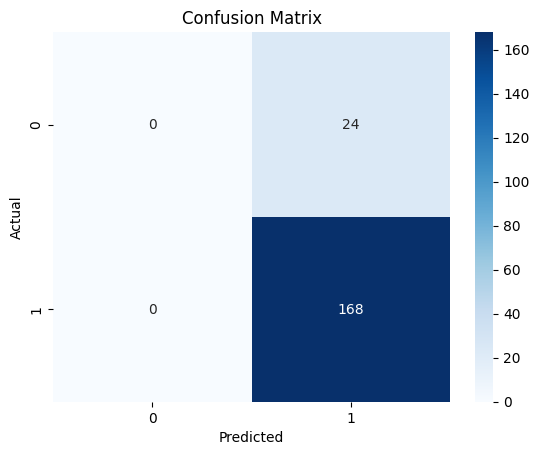

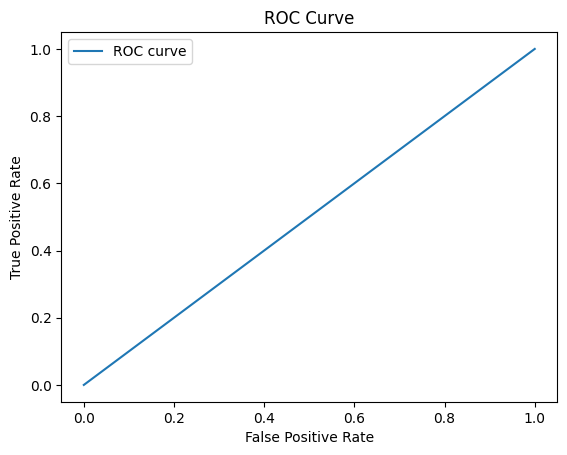

In [111]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities and classes
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AU-ROC:", roc_auc_score(y_test, y_pred_prob))
print("AU-PRC:", average_precision_score(y_test, y_pred_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [119]:
# For a new file, extract features as before
mfccs = features_extractor(r'C:\Users\uamaa\Bee-accoustic\archive\sound_files\sound_files\2022-07-15--15-28-21_2__segment4.wav')
mfccs_input = mfccs.reshape(1, -1)
prob = model.predict(mfccs_input)[0, 0]
print(f"Queen Presence Probability: {prob:.2f}")
print("Predicted:", "Present" if prob > 0.8 else "Absent")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Queen Presence Probability: 0.94
Predicted: Present


# References
- Dataset:
Anna Yang. (2022). Smart Bee Colony Monitor: Clips of Beehive Sounds. Kaggle.
https://www.kaggle.com/datasets/annajyang/beehive-sounds?select=sound_files
DOI: 10.34740/KAGGLE/DSV/4451415

- Librosa documentation

- TensorFlow Keras Guides

<details>
<summary>BibTeX Citation</summary>

```bibtex
@misc{anna_yang_2022,
  title={Smart Bee Colony Monitor: Clips of Beehive Sounds},
  url={https://www.kaggle.com/dsv/4451415},
  DOI={10.34740/KAGGLE/DSV/4451415},
  publisher={Kaggle},
  author={Anna Yang},
  year={2022}
}
